## Generate small patches from dataset
### Dependencies

In [12]:
import os
import glob
import json
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import compress
from common.utils import (
    normalize_seismic_data,
    get_sliding_wnd_params,
    get_sliding_wnd_patches
)

### Dataset related parameters

In [13]:
stage = 'train'
dataset_range = {
    'train': range(1, 10),
    'val': range(1, 3),
    'test': range(1, 8)
}
dataset_root = './dataset'
dataset_org = f'{dataset_root}/thebe_origin'
dataset_proc = f'{dataset_root}/thebe_processed'

os.makedirs(dataset_proc, exist_ok=True)

### Patch related parameters

In [14]:
patch_sz = 96
step = 48
px_th = int(0.03 * patch_sz * patch_sz)

patch_params = {
    'patch_sz': patch_sz,
    'step': step,
    'px_th': px_th
}

with open(f'{dataset_proc}/patch_params.json', 'w+') as f:
    json.dump(patch_params, f)

### Split input seismic images into patches

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain1.npy


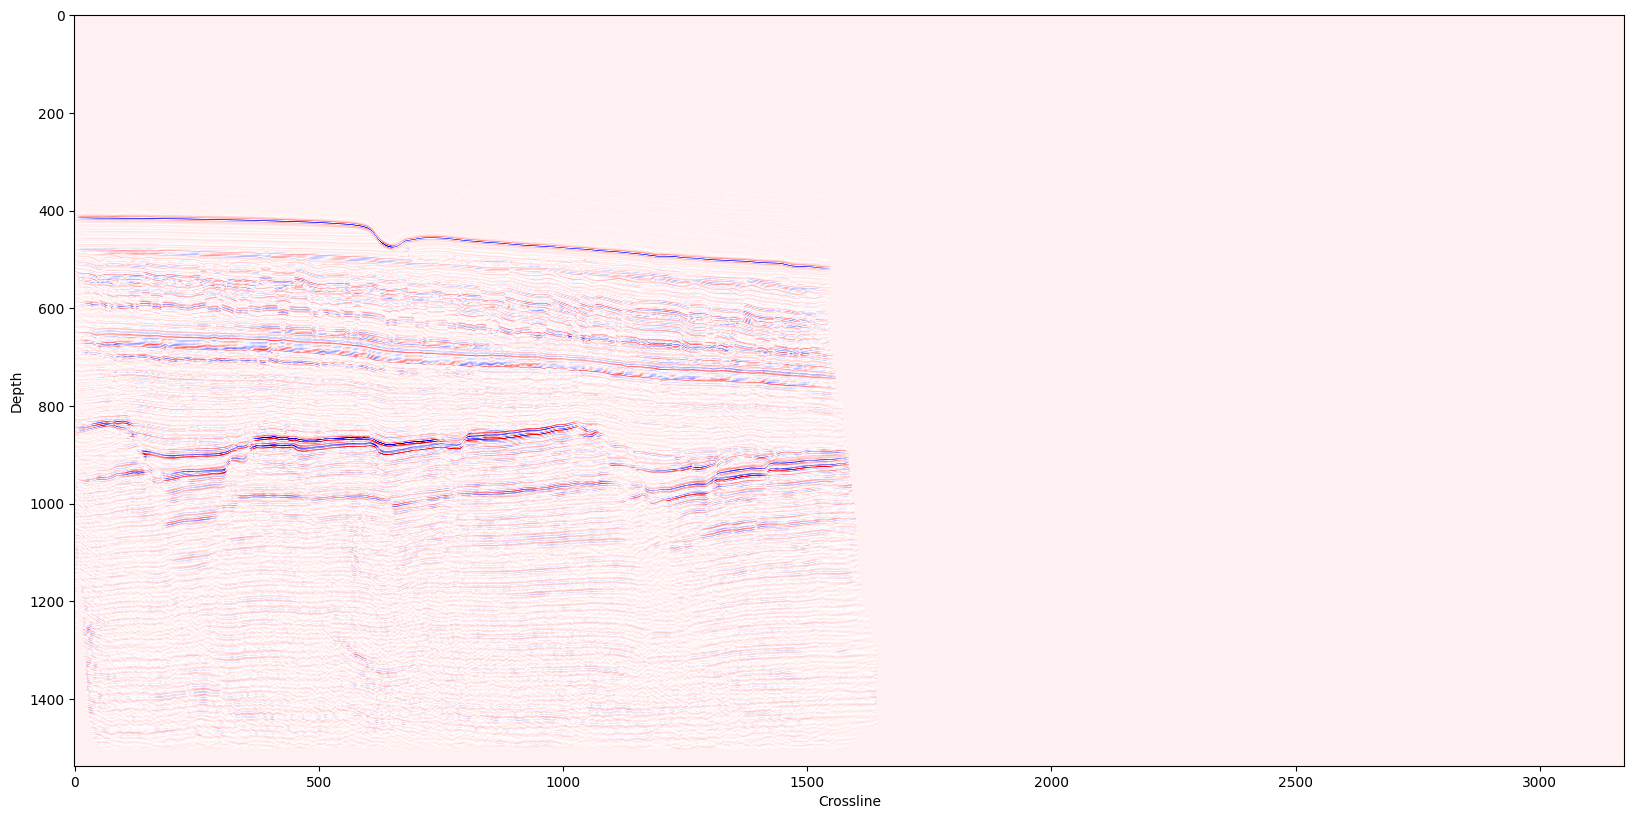

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain2.npy


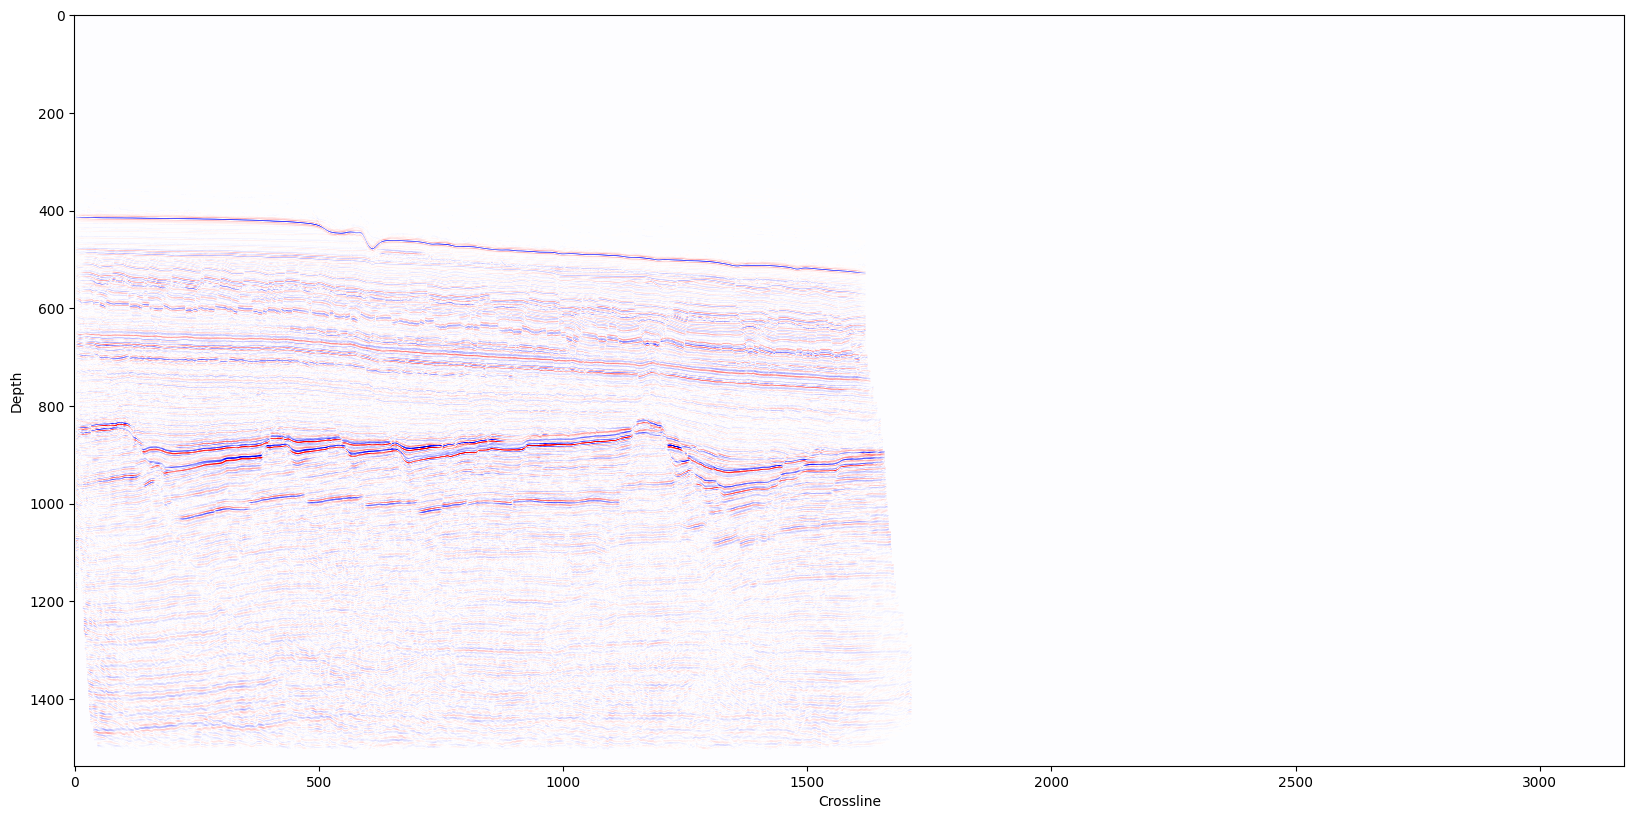

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain3.npy


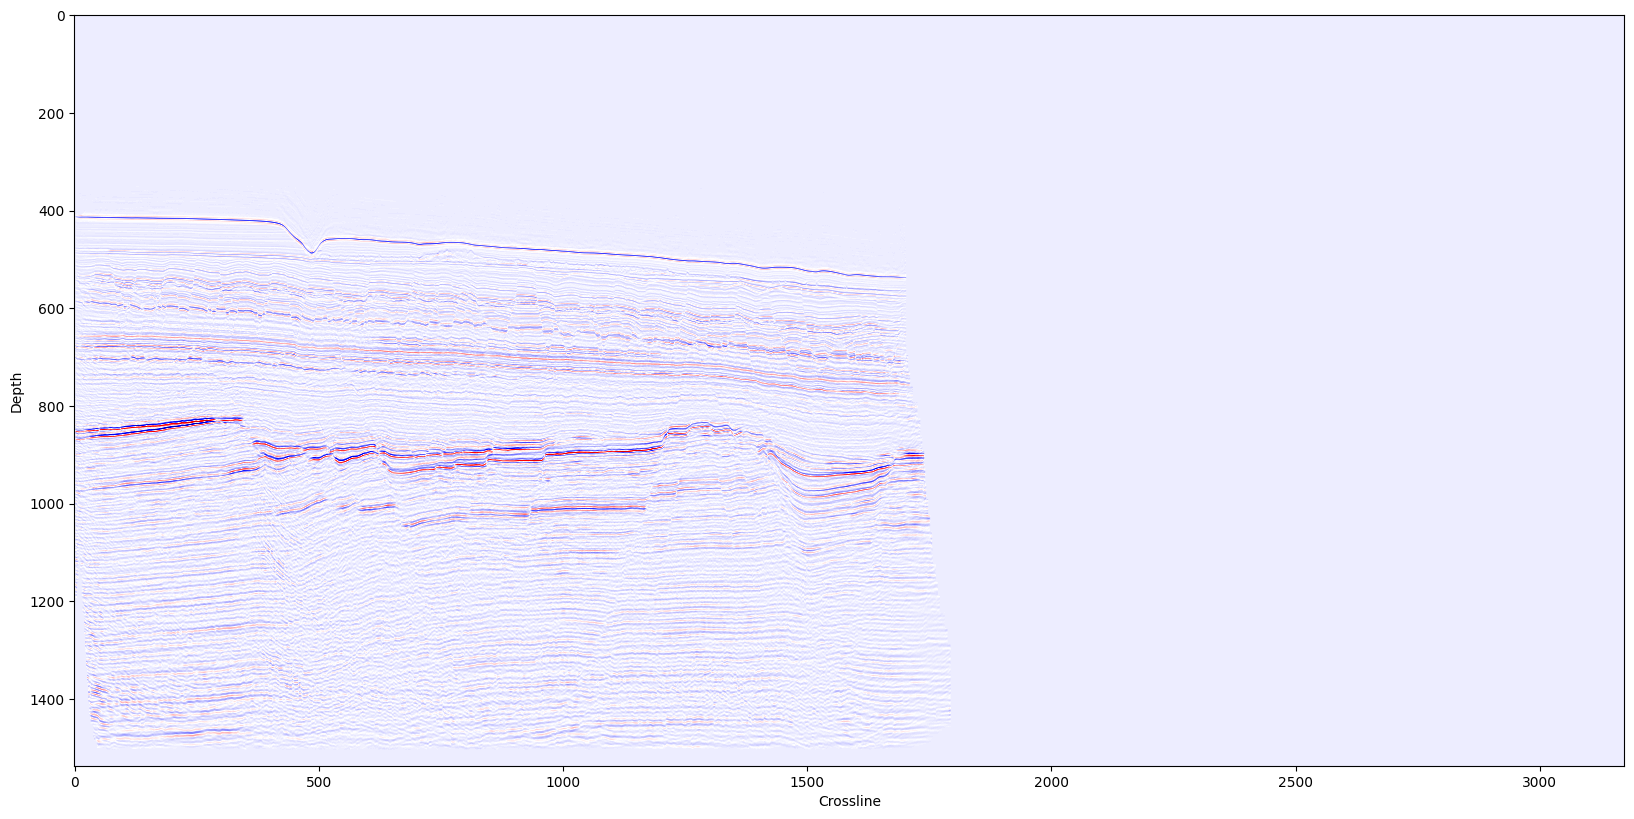

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain4.npy


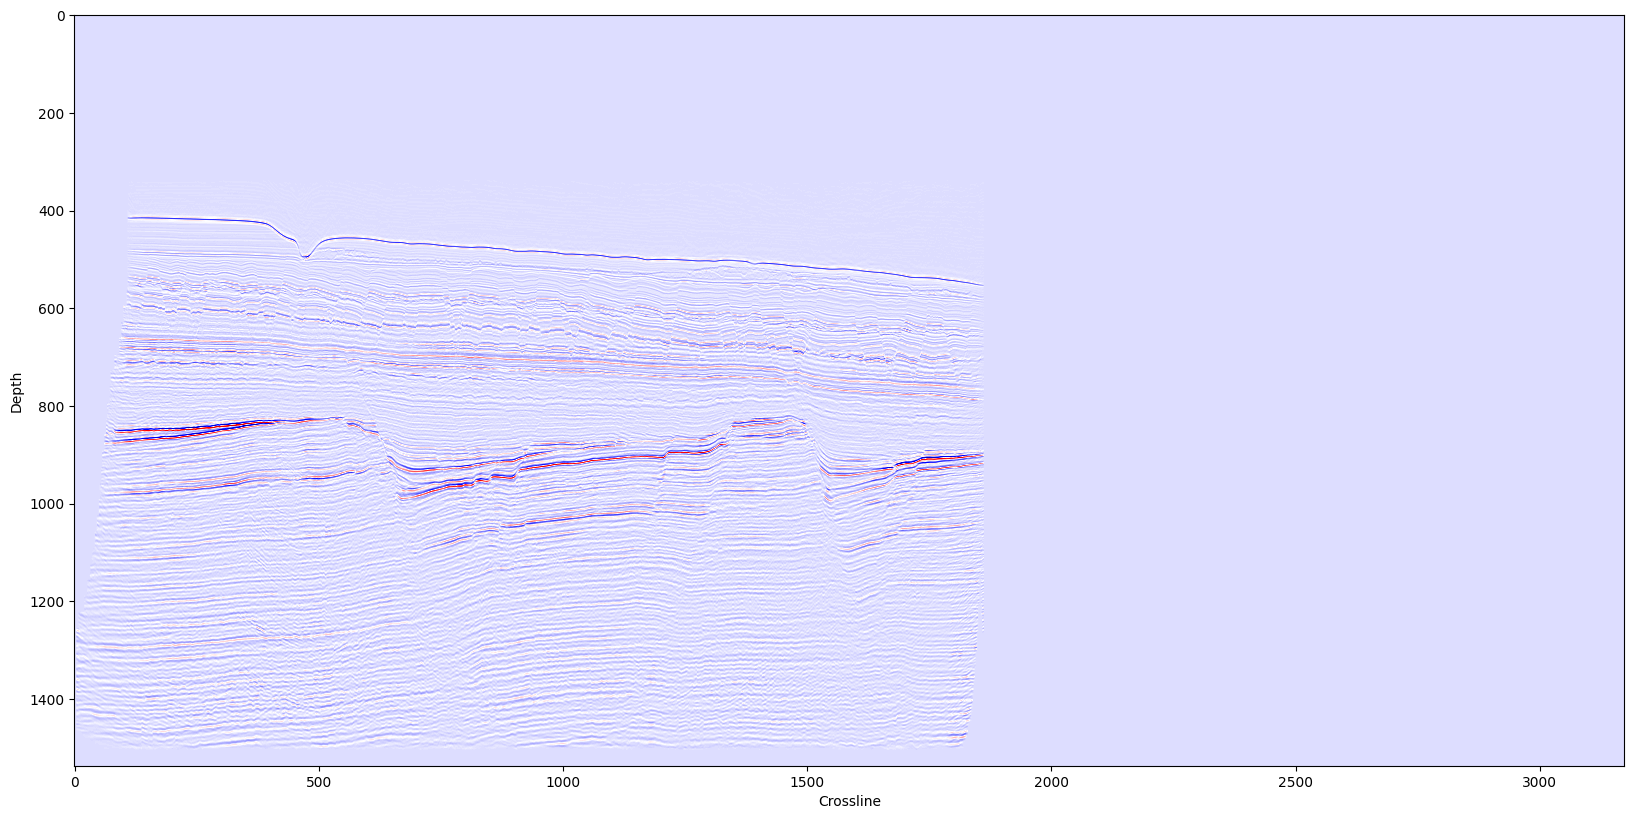

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain5.npy


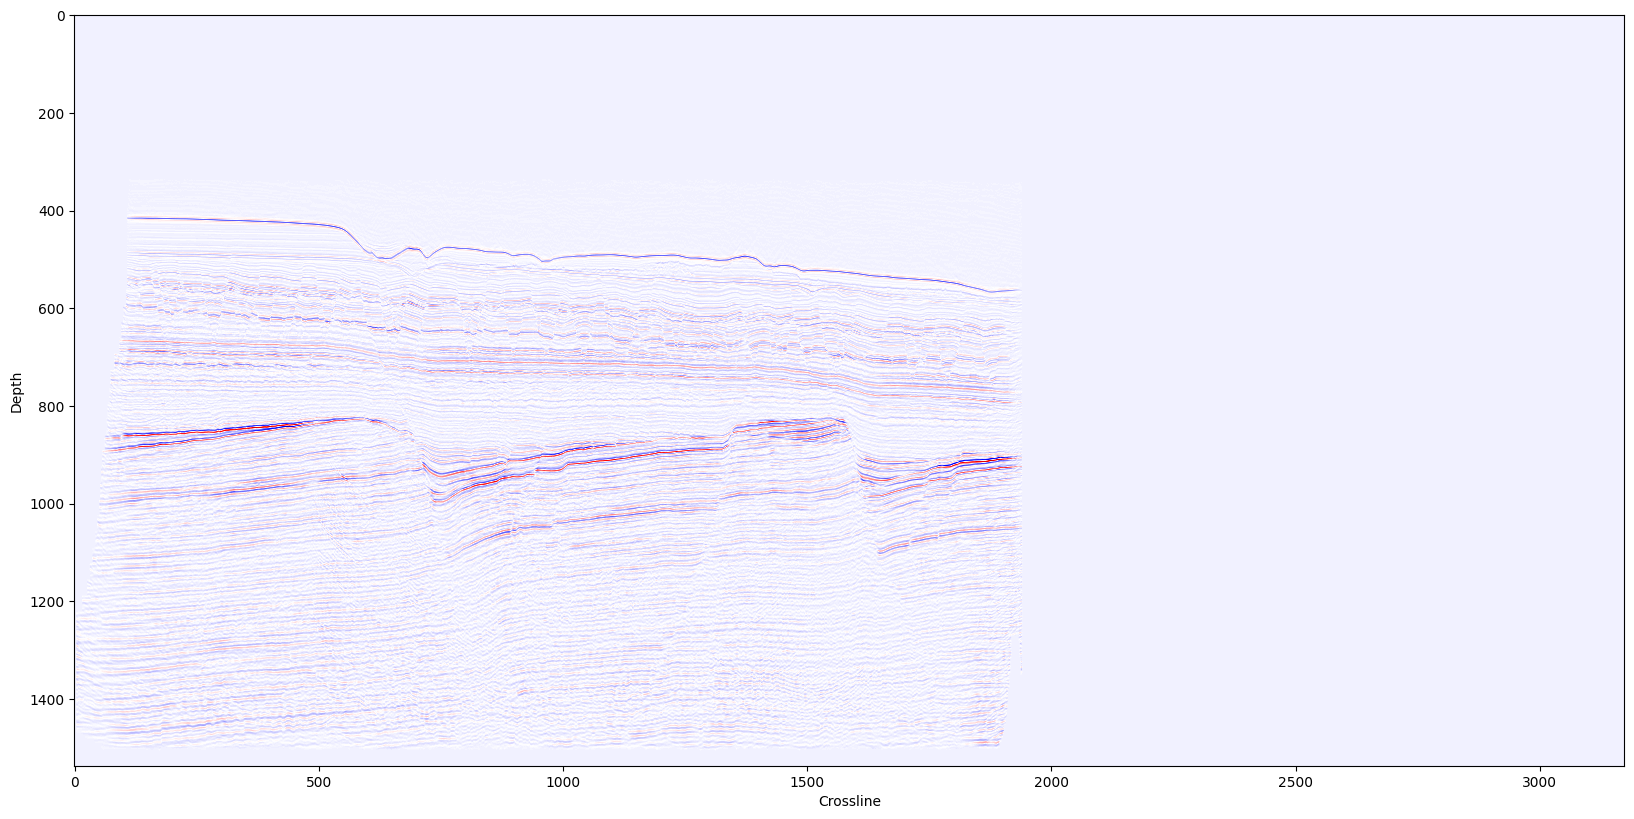

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain6.npy


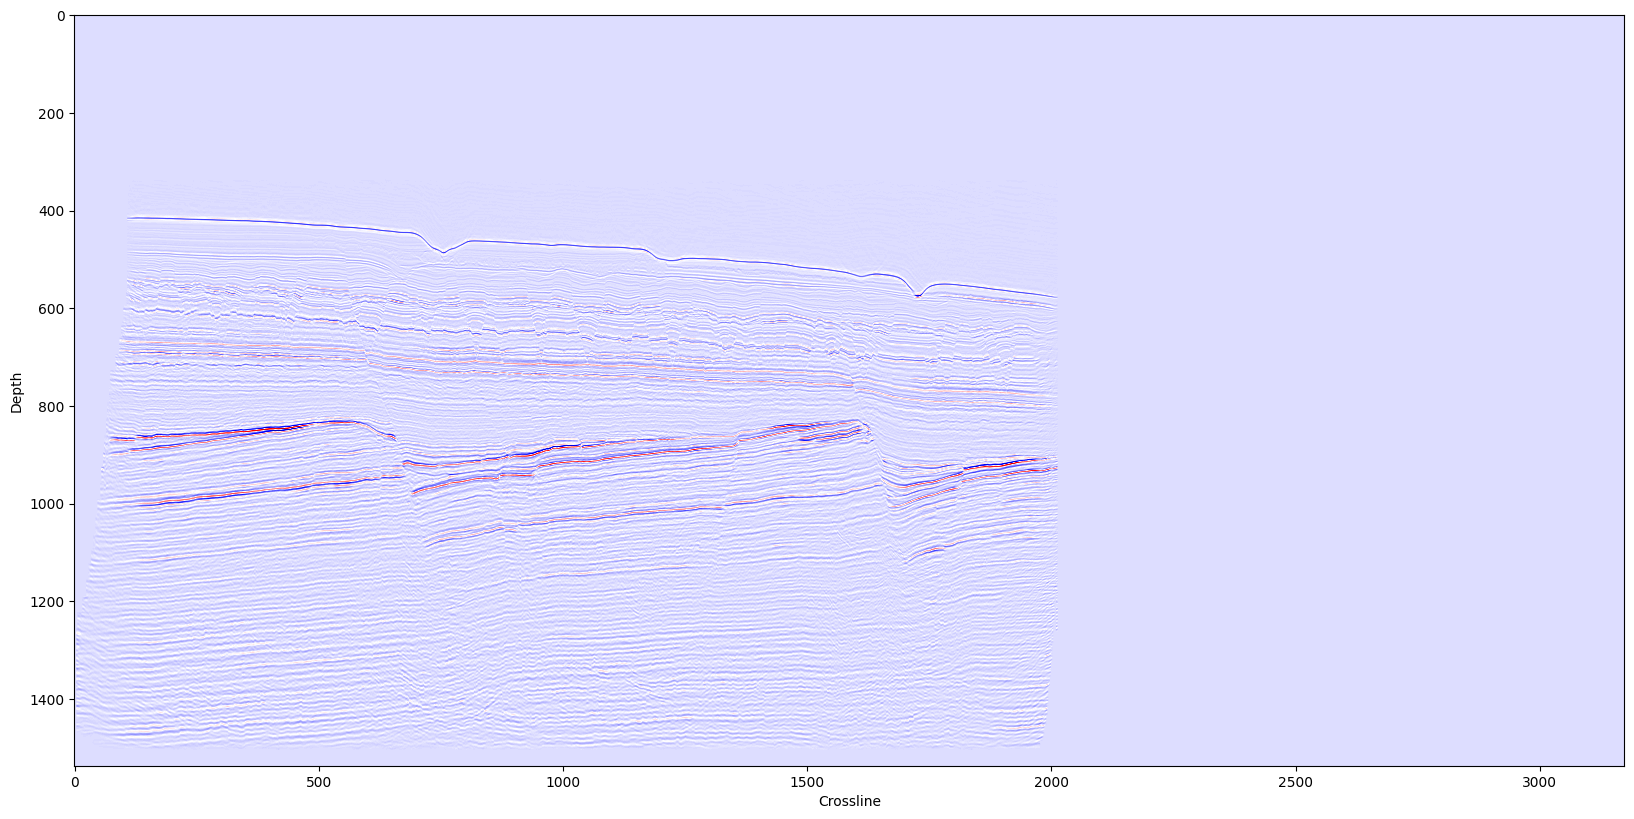

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain7.npy


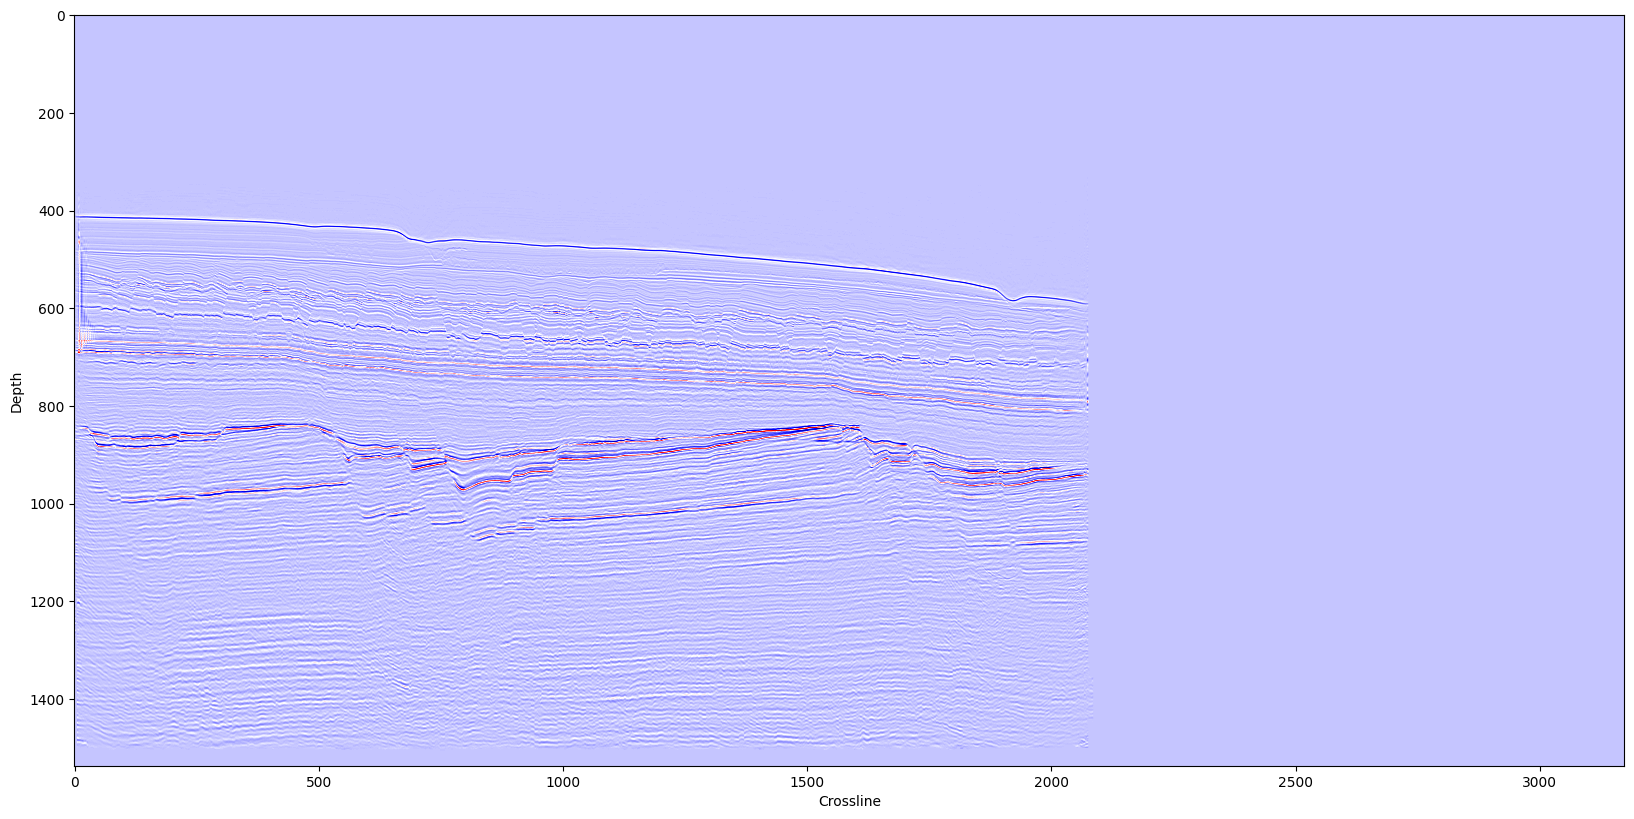

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain8.npy


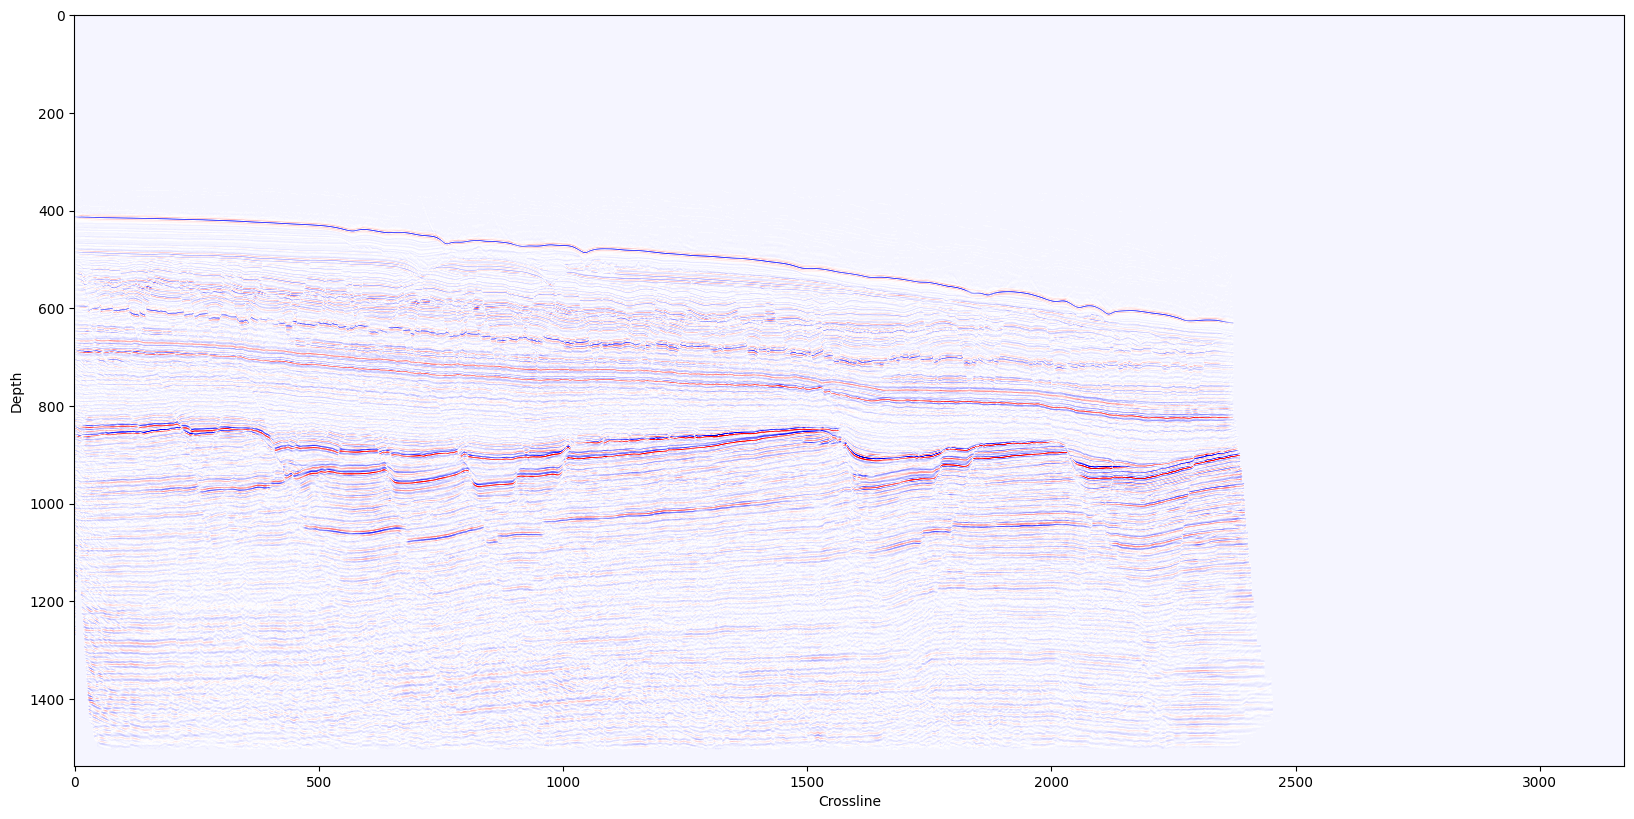

(100, 1537, 3174)
First inline section for ./dataset/thebe_origin/seistrain9.npy


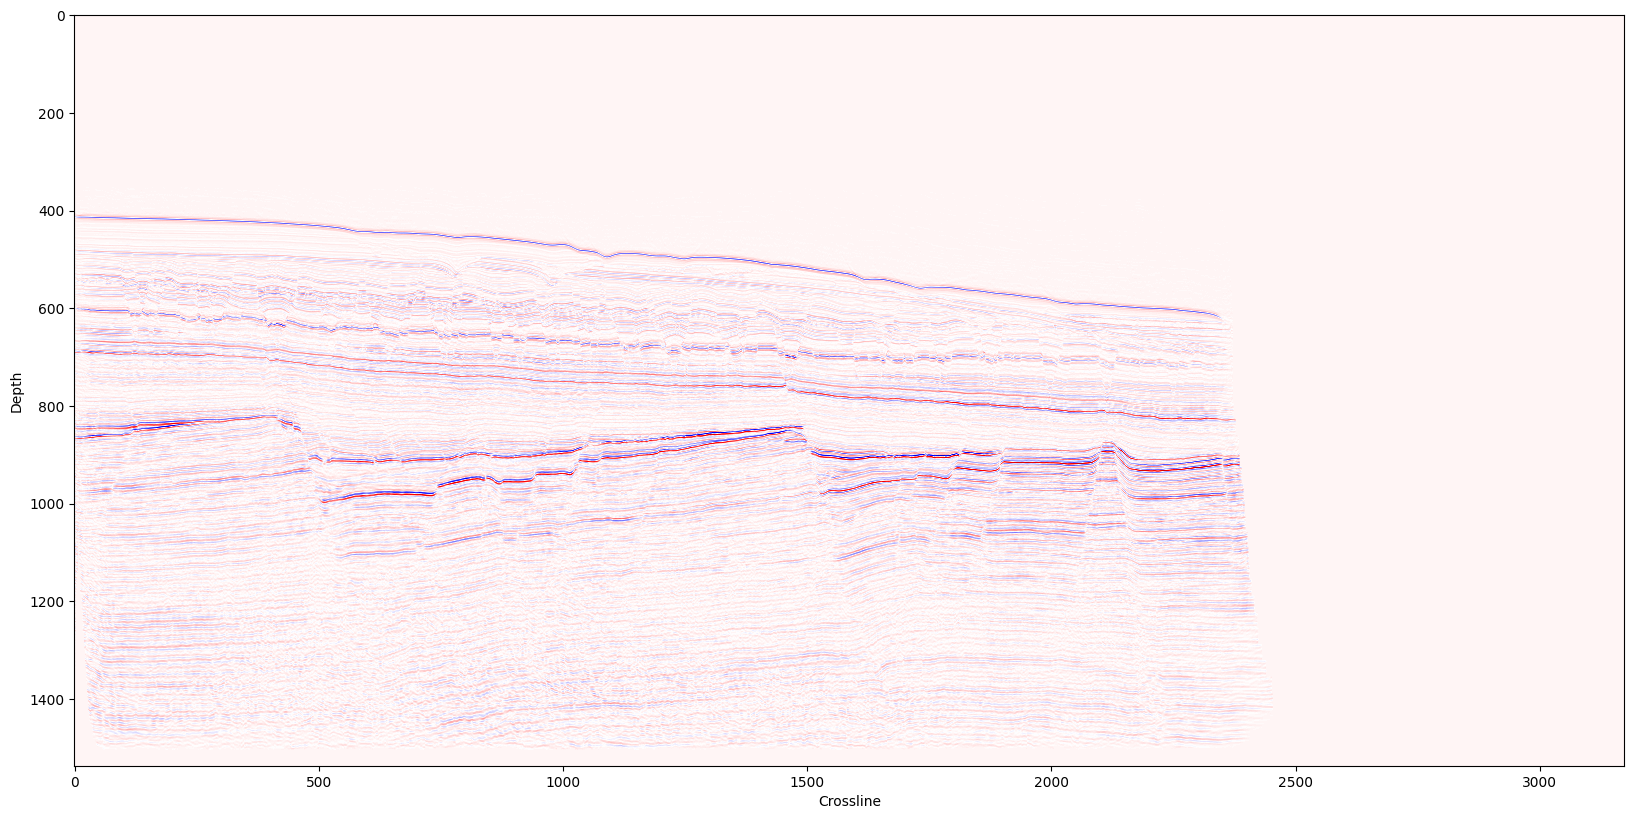

In [15]:
X = []
Y = []
for i in dataset_range[stage]:
    seismic_path = f'{dataset_org}/seis{stage}{i}.npy'
    fault_path = f'{dataset_org}/fault{stage}{i}.npy'

    # make it IL, Z, XL order
    seismic = np.load(seismic_path)
    fault = np.load(fault_path)

    seismic = np.moveaxis(seismic, -2, -1)
    fault = np.moveaxis(fault, -2, -1)

    seismic = normalize_seismic_data(seismic)

    IL, Z, XL = fault.shape
    print(fault.shape)

    padding, _ = get_sliding_wnd_params((XL, Z), patch_sz, step)

    for j in range(0, IL):
        if j == 0:
            print(f'First inline section for {seismic_path}')
            plt.figure(figsize=(20, 16))
            plt.imshow(seismic[j], cmap='seismic')
            plt.xlabel('Crossline')
            plt.ylabel('Depth')
            plt.show()
        
        if stage == 'test':
            X.append(seismic[j])
            Y.append(fault[j])
            continue

        patches = get_sliding_wnd_patches(fault[j], padding, patch_sz, step)
        t = (patches.sum((1, 2)) < px_th)
        invalid_idx = list(compress(range(len(t)), t))
        patches = np.delete(patches, invalid_idx, 0)
        Y.extend(patches)

        patches = get_sliding_wnd_patches(seismic[j], padding, patch_sz, step)
        patches = np.delete(patches, invalid_idx, 0)
        X.extend(patches)


### Save patches

In [16]:
os.makedirs(f'{dataset_proc}/{stage}/seismic', exist_ok=True)
os.makedirs(f'{dataset_proc}/{stage}/annotation', exist_ok=True)

X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)
for i in range(len(X)):
    np.save(f'{dataset_proc}/{stage}/seismic/{i:08}.npy', X[i])
    np.save(f'{dataset_proc}/{stage}/annotation/{i:08}.npy', Y[i])

### Illustrate patches

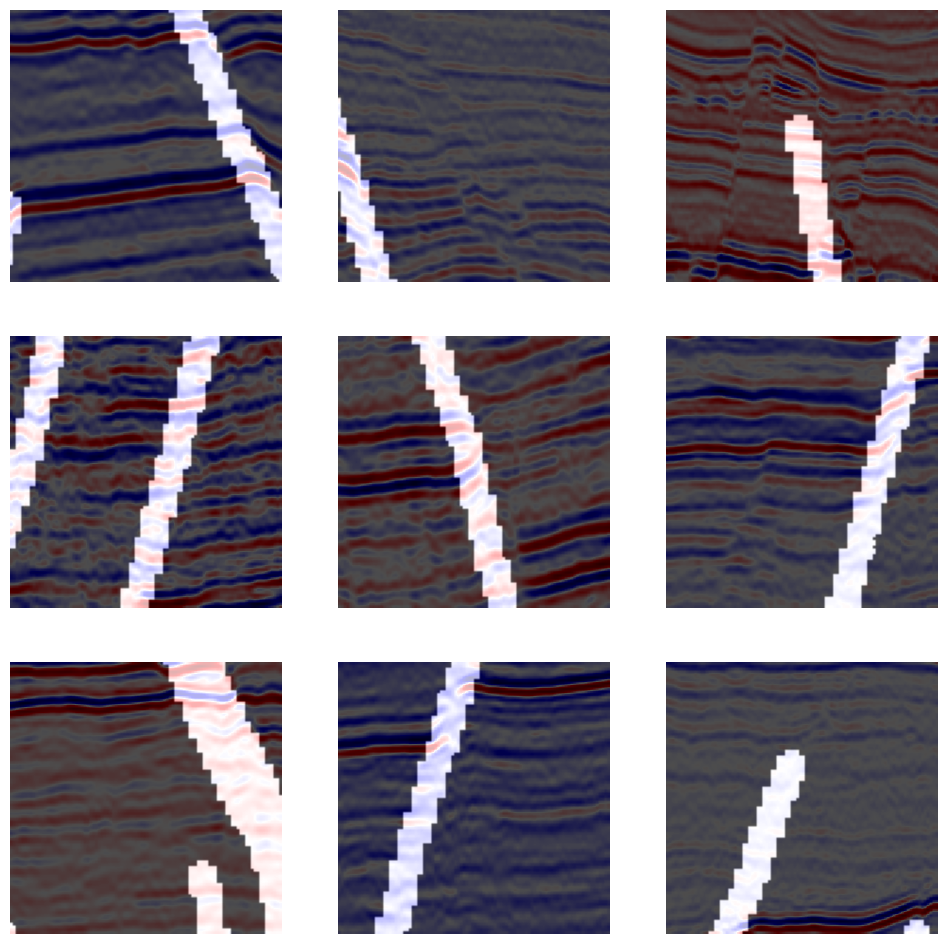

In [17]:
fault_list = glob.glob(f'{dataset_proc}/{stage}/annotation/*.npy')

random.seed()
plt.figure(figsize=(12, 12))
for i in range(9):
    sample = random.randint(0, len(fault_list))
    seismic = np.load(f'{dataset_proc}/{stage}/seismic/{sample:08}.npy')
    fault = np.load(f'{dataset_proc}/{stage}/annotation/{sample:08}.npy')
    plt.subplot(int(f'33{i + 1}'))
    plt.imshow(seismic, cmap='seismic')
    plt.imshow(fault, cmap='gray', alpha=0.7)
    plt.axis('off')